# Predicting COVID-19 cases with ARIMA and ANNs

## Importing Libraries

In [1]:
import math
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm
from datetime import date
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%load_ext nb_black

# Defaults
plt.rcParams["figure.figsize"] = (15.0, 10.0)
plt.rcParams.update({"font.size": 12, "figure.dpi": 120})
warnings.filterwarnings("ignore")  # specify to ignore warning messages

<IPython.core.display.Javascript object>

## Data Handling

In [2]:
def preprocess(df):
    df = df.drop(["Lat", "Long"], axis=1)
    df = df.groupby(["Country/Region"], as_index=False).sum()
    df.loc[-1] = df.sum()
    df.loc[-1, "Country/Region"] = "Worldwide"
    countries = [
        "US",
        "Germany",
        "Spain",
        "United Kingdom",
        "France",
        "India",
        "Iran",
        "Italy",
        "Russia",
        "Turkey",
        #         "Worldwide",
    ]
    df = df.loc[df["Country/Region"].isin(countries)]
    df.reset_index(drop=True, inplace=True)
    df = df.set_index("Country/Region")
    df.columns = pd.to_datetime(df.columns)
    df = df.T
    return df

<IPython.core.display.Javascript object>

In [3]:
confirmed_df = pd.read_csv(
    "./csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
)
confirmed_df = preprocess(confirmed_df)
deaths_df = pd.read_csv(
    "./csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
)
deaths_df = preprocess(deaths_df)
recovered_df = pd.read_csv(
    "./csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
)
recovered_df = preprocess(recovered_df)

<IPython.core.display.Javascript object>

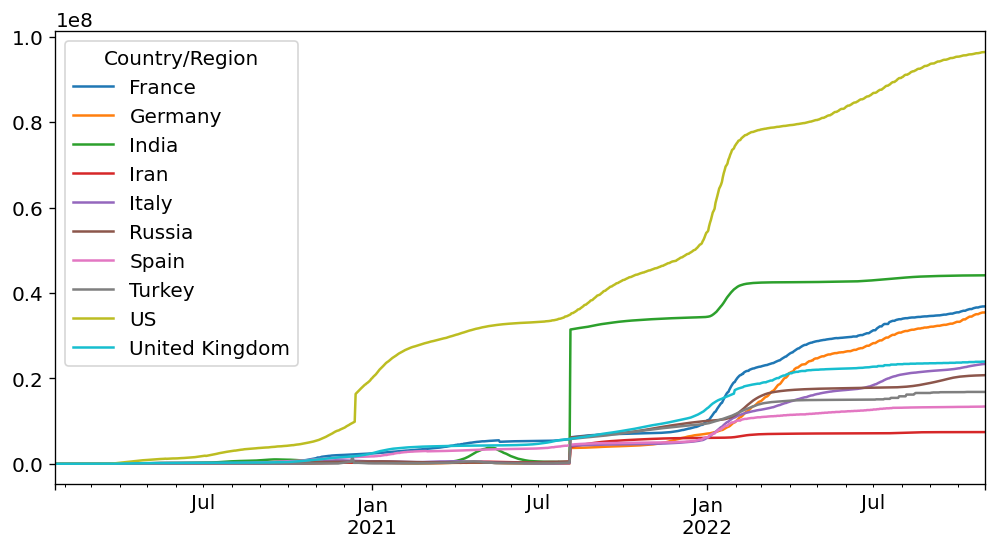

<IPython.core.display.Javascript object>

In [4]:
active_df = pd.DataFrame(confirmed_df - deaths_df - recovered_df)
active_df.plot(figsize=(10, 5))
plt.show()

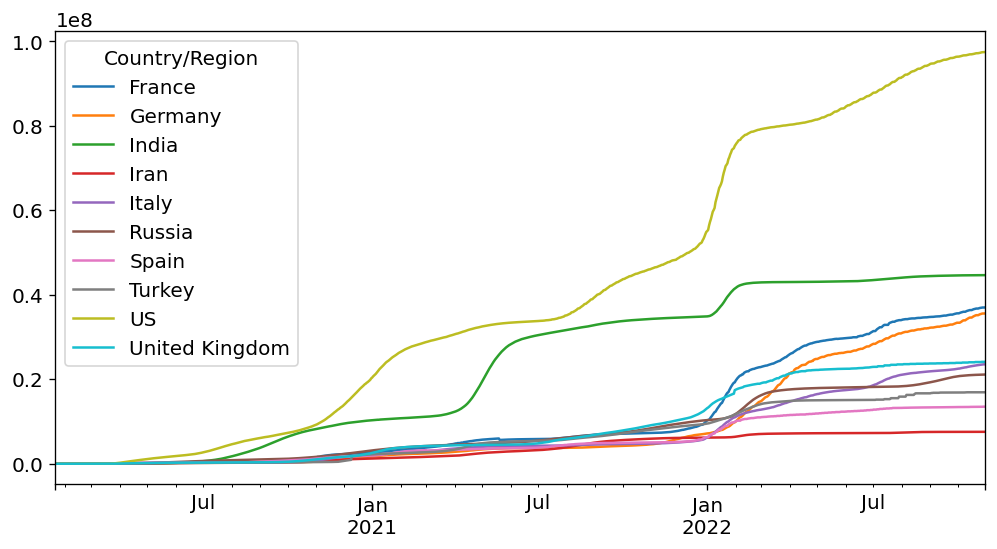

<IPython.core.display.Javascript object>

In [5]:
confirmed_df.plot(figsize=(10, 5))
plt.show()

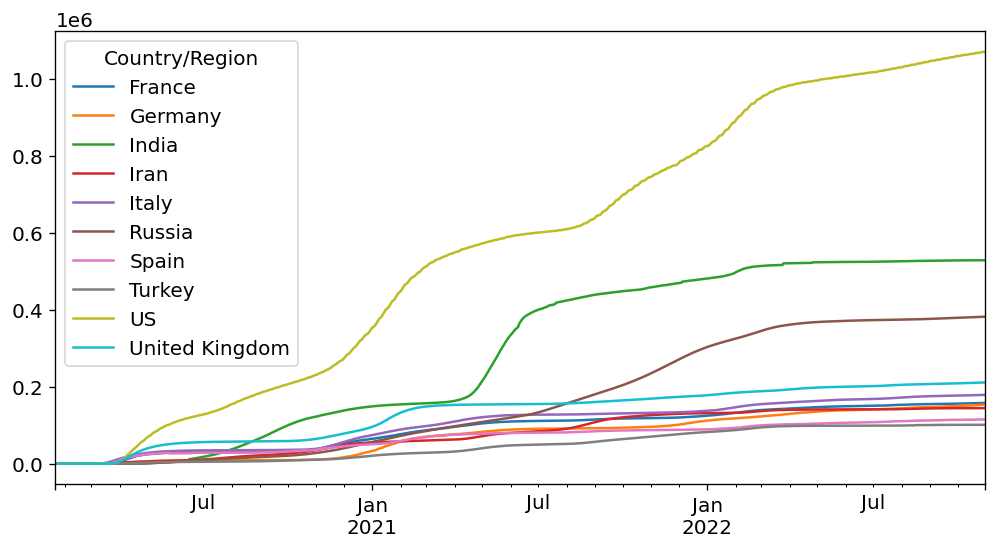

<IPython.core.display.Javascript object>

In [6]:
deaths_df.plot(figsize=(10, 5))
plt.show()

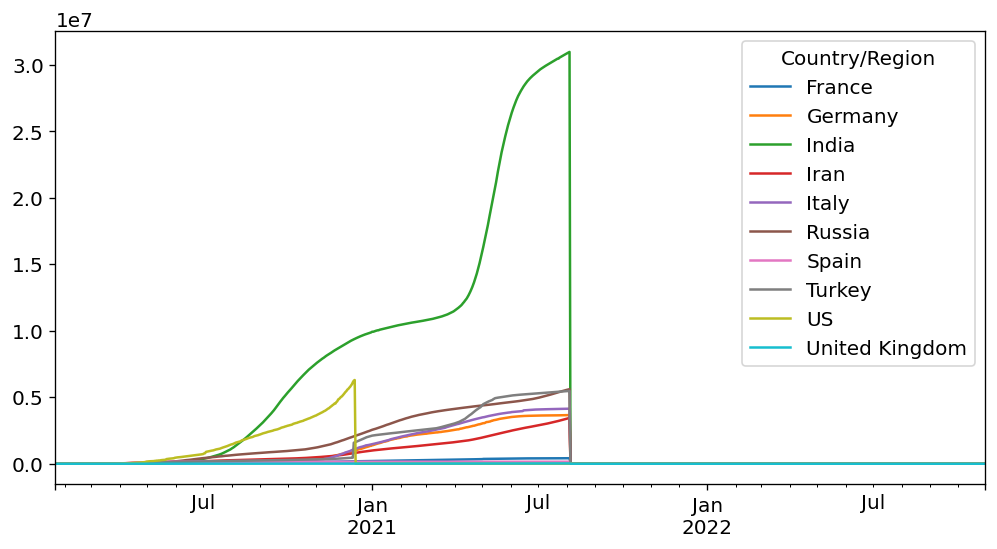

<IPython.core.display.Javascript object>

In [7]:
recovered_df.plot(figsize=(10, 5))
plt.show()

### Train test split

In [8]:
active_train = active_df["2020-02-04":"2021-08-04"]
active_test = active_df["2021-04-23":"2021-04-08"]
confirmed_train = confirmed_df["2020-01-22":"2021-04-22"]
confirmed_test = confirmed_df["2021-04-23":"2021-04-08"]

<IPython.core.display.Javascript object>

## Model Selection

### Determining order of differencing (d)

In [9]:
# Original Series
country = "India"
df = pd.DataFrame((active_train[country].to_numpy()), columns={"cases"})
df.transform("sqrt")

,cases
0,1.732051
1,1.732051
2,1.732051
3,1.732051
4,1.732051
...,...
543,641.055380
544,643.209142
545,636.363104
546,640.588011


<IPython.core.display.Javascript object>

In [10]:
result = adfuller(df)
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("Critical Values:")
for key, value in result[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: -2.440185
p-value: 0.130714
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


<IPython.core.display.Javascript object>

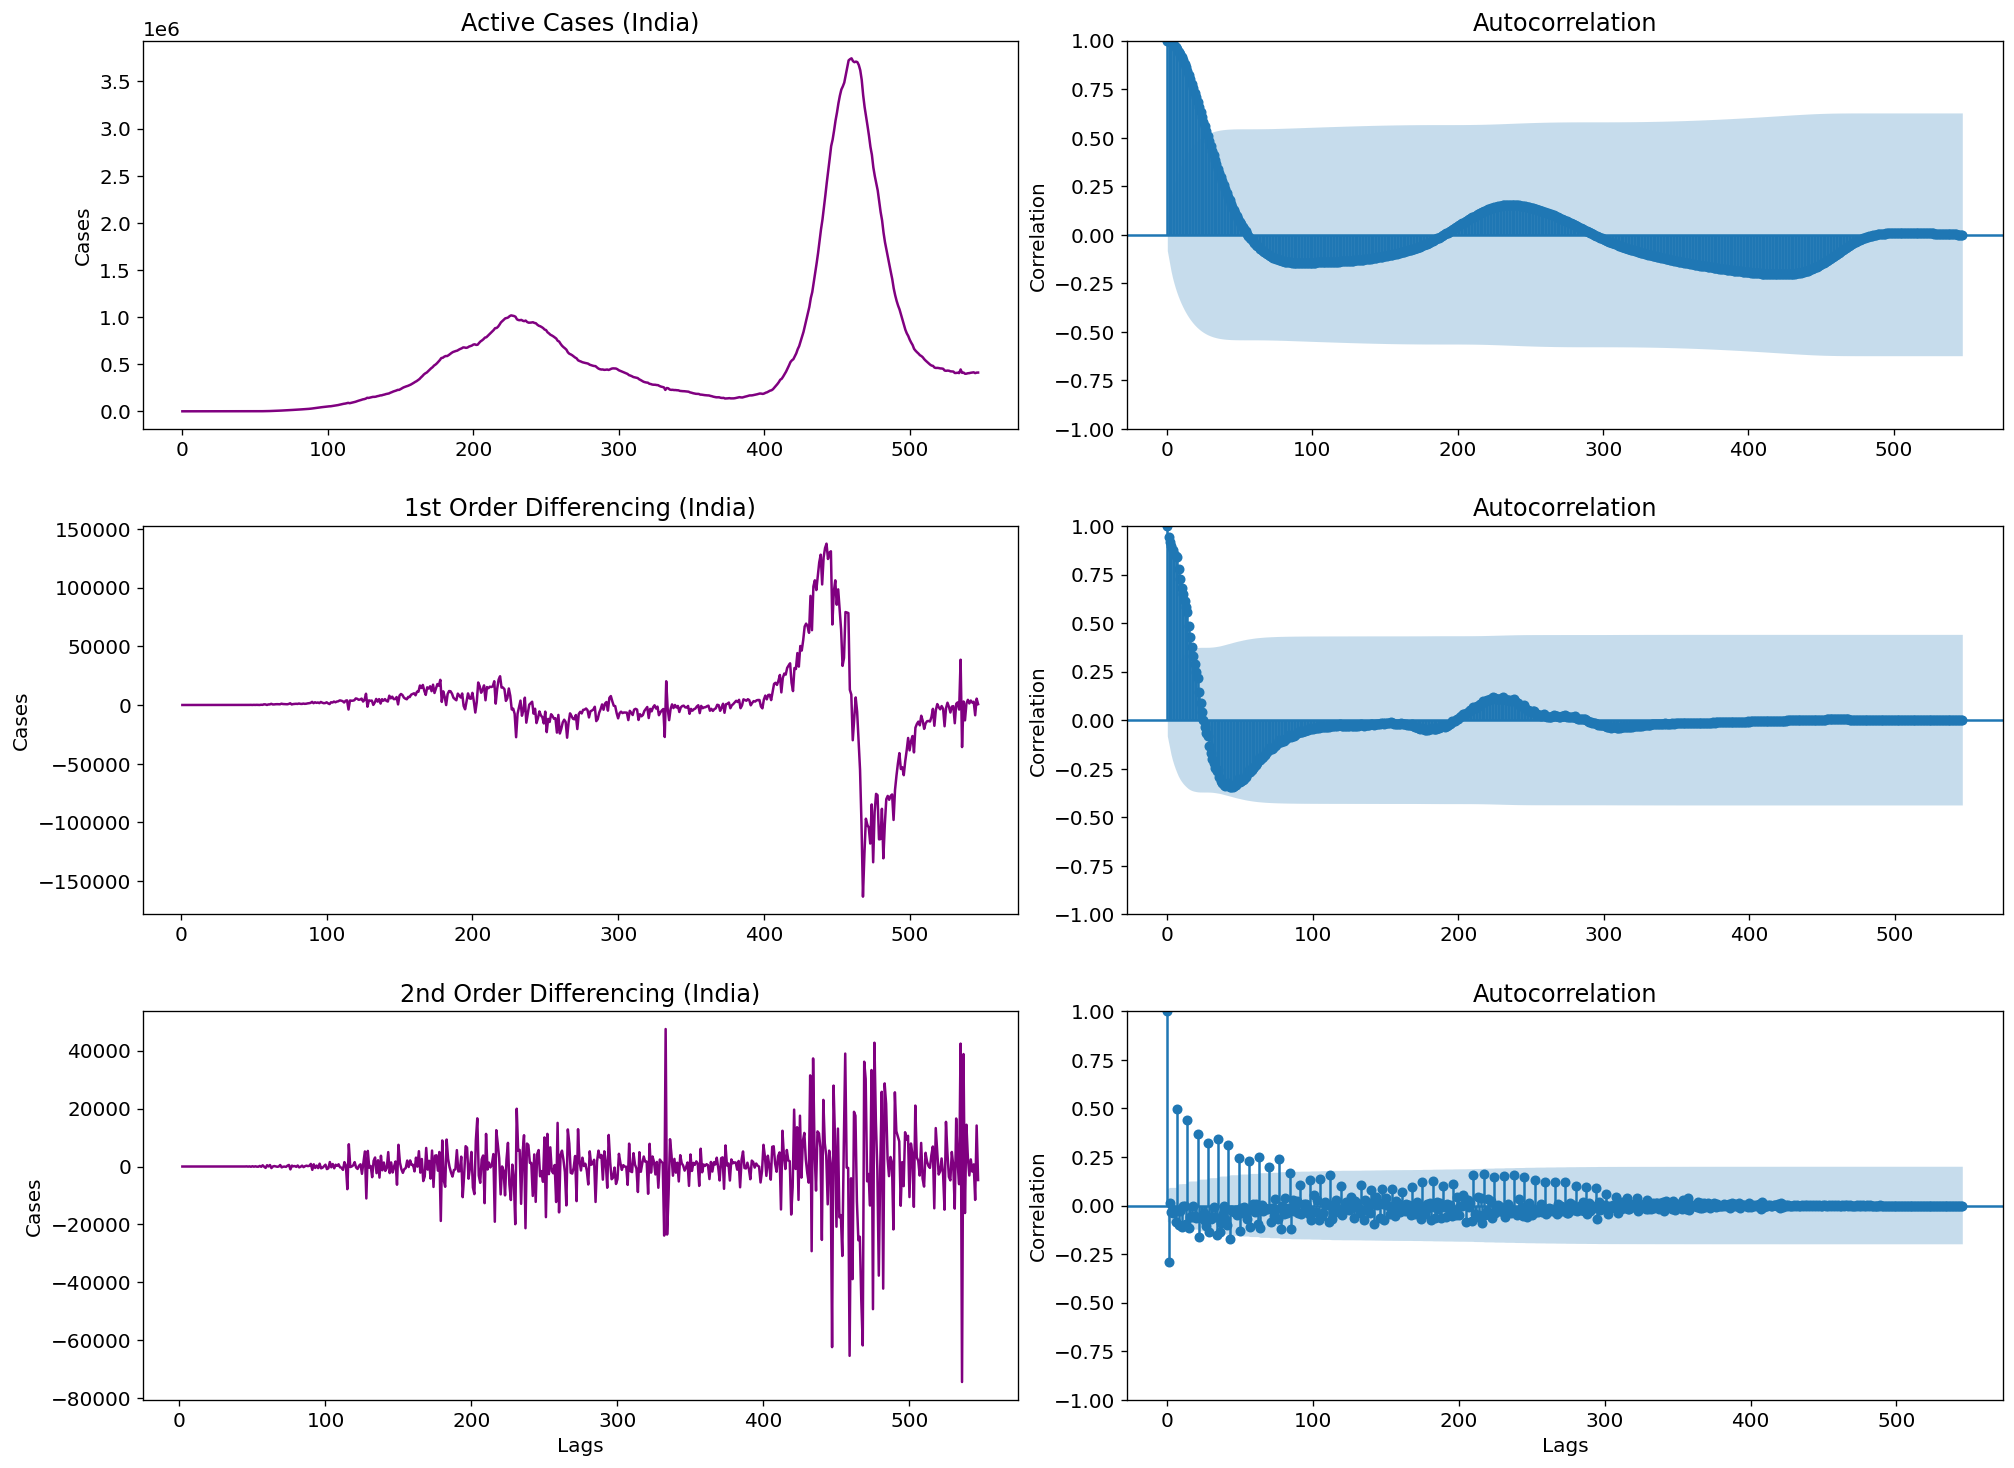

<IPython.core.display.Javascript object>

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.subplots_adjust(hspace=0.250, wspace=0.125)
axes[0, 0].plot(df, "purple")
axes[0, 0].set(title=f"Active Cases ({country})", ylabel="Cases")
plot_acf(df, ax=axes[0, 1], lags=df.shape[0] - 1)
axes[0, 1].set(ylabel="Correlation")

# 1st Differencing
axes[1, 0].plot(df.diff(), "purple")
axes[1, 0].set(title=f"1st Order Differencing ({country})", ylabel="Cases")
plot_acf(df.diff().dropna(), ax=axes[1, 1], lags=df.shape[0] - 2)
axes[1, 1].set(ylabel="Correlation")


# 2nd Differencing
axes[2, 0].plot(df.diff().diff(), "purple")
axes[2, 0].set(
    xlabel="Lags", ylabel="Cases", title=f"2nd Order Differencing ({country})"
)
axes[2, 1].set_xlabel("Lags")
plot_acf(df.diff().diff().dropna(), ax=axes[2, 1], lags=df.shape[0] - 3)
axes[2, 1].set(ylabel="Correlation")

fig.savefig("Graphs/1.acf_plots.jpg")
plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the second differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.
$$d = 1 $$

### Determining order of Auto-Regression (p)

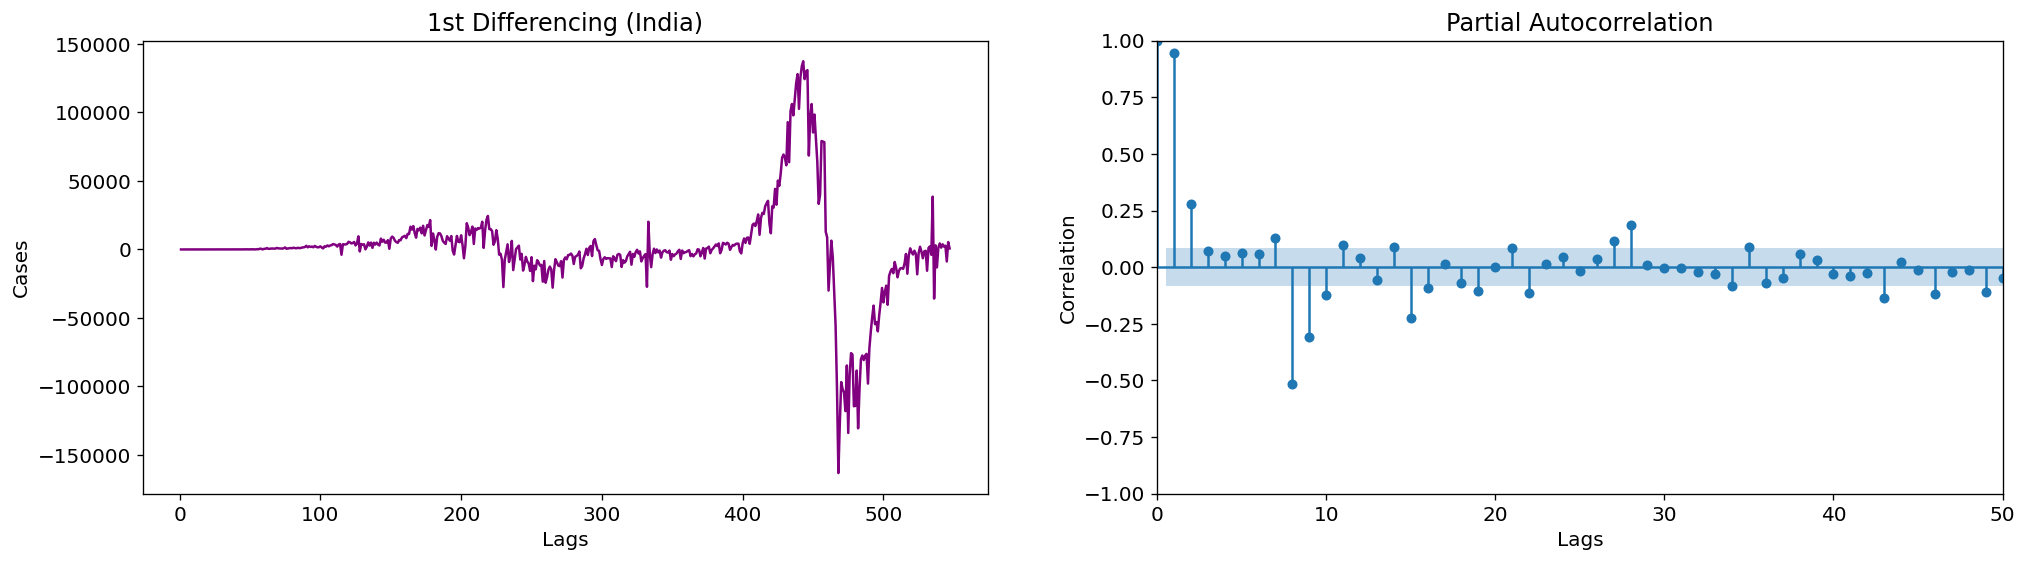

<IPython.core.display.Javascript object>

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(df.diff(), "purple")
ax1.set(title=f"1st Differencing ({country})", xlabel="Lags", ylabel="Cases")
plot_pacf(df.diff().dropna(), ax=ax2, lags=272)
ax2.set(xlabel="Lags", ylabel="Correlation", ylim=(-1, 1), xlim=(0, 50))
fig.savefig("Graphs/2.pacf_plots.jpg")
plt.show()

It can observed that the PACF lag 1, 2 and 3 are quite significant since they are well above the significance limit, the blue region.
So we will use:
$$p \in \{1, 2\}$$

### Determining order of Moving Average (q)

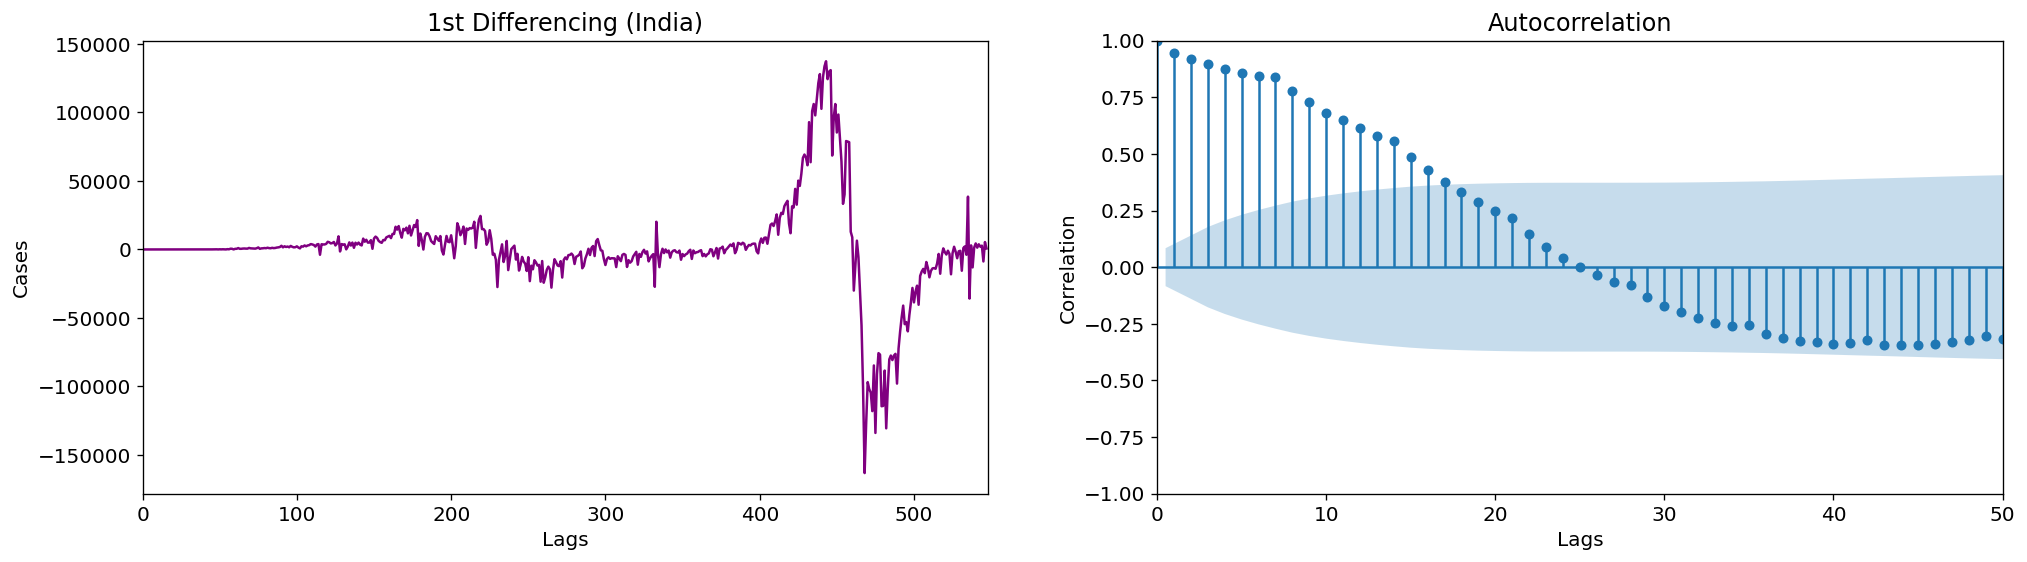

<IPython.core.display.Javascript object>

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].plot(df.diff(), "purple")
axes[0].set(
    title=f"1st Differencing ({country})",
    xlabel="Lags",
    ylabel="Cases",
    xlim=(0, df.shape[0]),
)
plot_acf(df.diff().dropna(), ax=axes[1], lags=df.shape[0] - 2)
axes[1].set(ylim=(-1, 1), xlim=(0, 50), xlabel="Lags", ylabel="Correlation")

fig.savefig("Graphs/3.acf_plots.jpg")
plt.show()

We can see that upto `lags` = 9, the correlation is above the significance range and so we can conclude that: $$q \in [1, 16]$$

In [14]:
# Define the p, d, q parameters
p = range(1, 4)
d = 1
q = range(1, 10)

<IPython.core.display.Javascript object>

### Using auto_arima() to select model

In [15]:
model = pm.auto_arima(
    df,
    start_p=1,
    start_q=1,
    test="adf",  # use adftest to find optimal 'd'
    max_p=3,
    max_q=3,  # maximum p and q
    m=1,  # frequency of series
    d=None,  # let model determine 'd'
    seasonal=False,  # No Seasonality
    start_P=0,
    D=0,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=12501.458, Time=0.88 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16701.073, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11731.644, Time=0.28 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11782.304, Time=0.26 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=11732.804, Time=0.71 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=11732.962, Time=0.54 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=12241.485, Time=1.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=11738.518, Time=0.19 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.41 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=11726.612, Time=0.63 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=12658.394, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=11781.038, Time=0.27 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   :

<IPython.core.display.Javascript object>

We can see that ARIMA(2, 0, 1) has the least AIC socre, so we save it as `best_order` and use it as our model

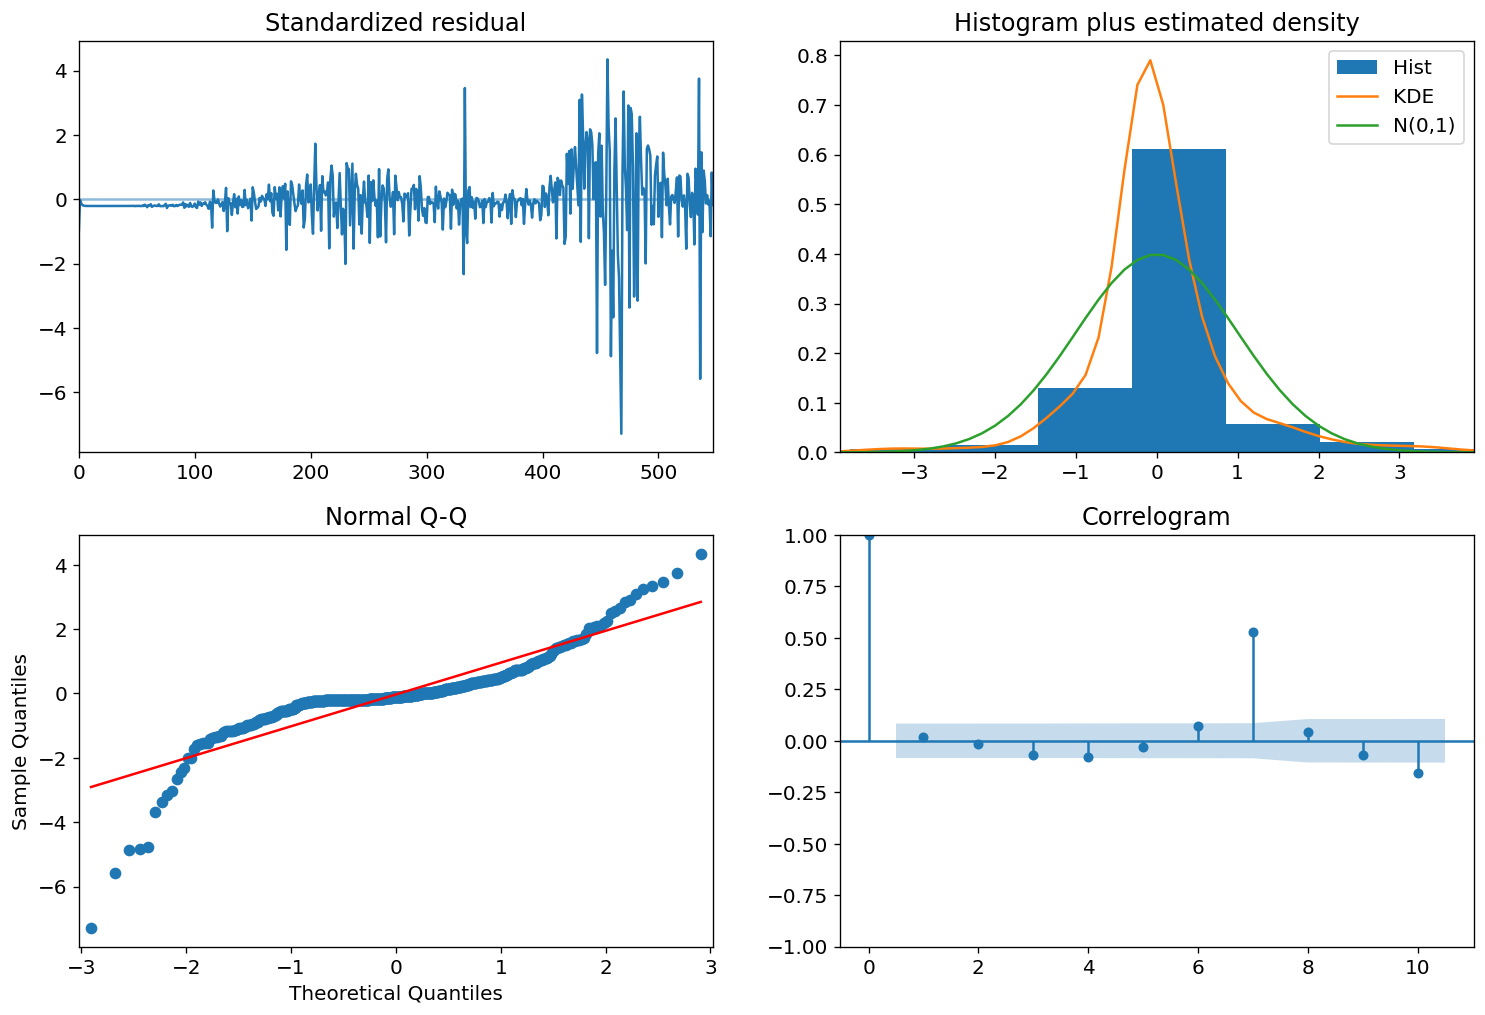

<IPython.core.display.Javascript object>

In [16]:
model.plot_diagnostics(figsize=(15, 10))
plt.savefig("Graphs/diagnostics_autoarima.jpg")
plt.show()

## Fitting ARIMA(2, 0, 1)

                               SARIMAX Results                                
Dep. Variable:                  cases   No. Observations:                  548
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -5857.710
Date:                Sat, 03 Dec 2022   AIC                          11725.420
Time:                        22:03:54   BIC                          11746.951
Sample:                             0   HQIC                         11733.836
                                - 548                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.018e+05   3.22e-10   1.87e+15      0.000    6.02e+05    6.02e+05
ar.L1          1.9756      0.005    430.324      0.000       1.967       1.985
ar.L2         -0.9773      0.005   -212.516      0.0

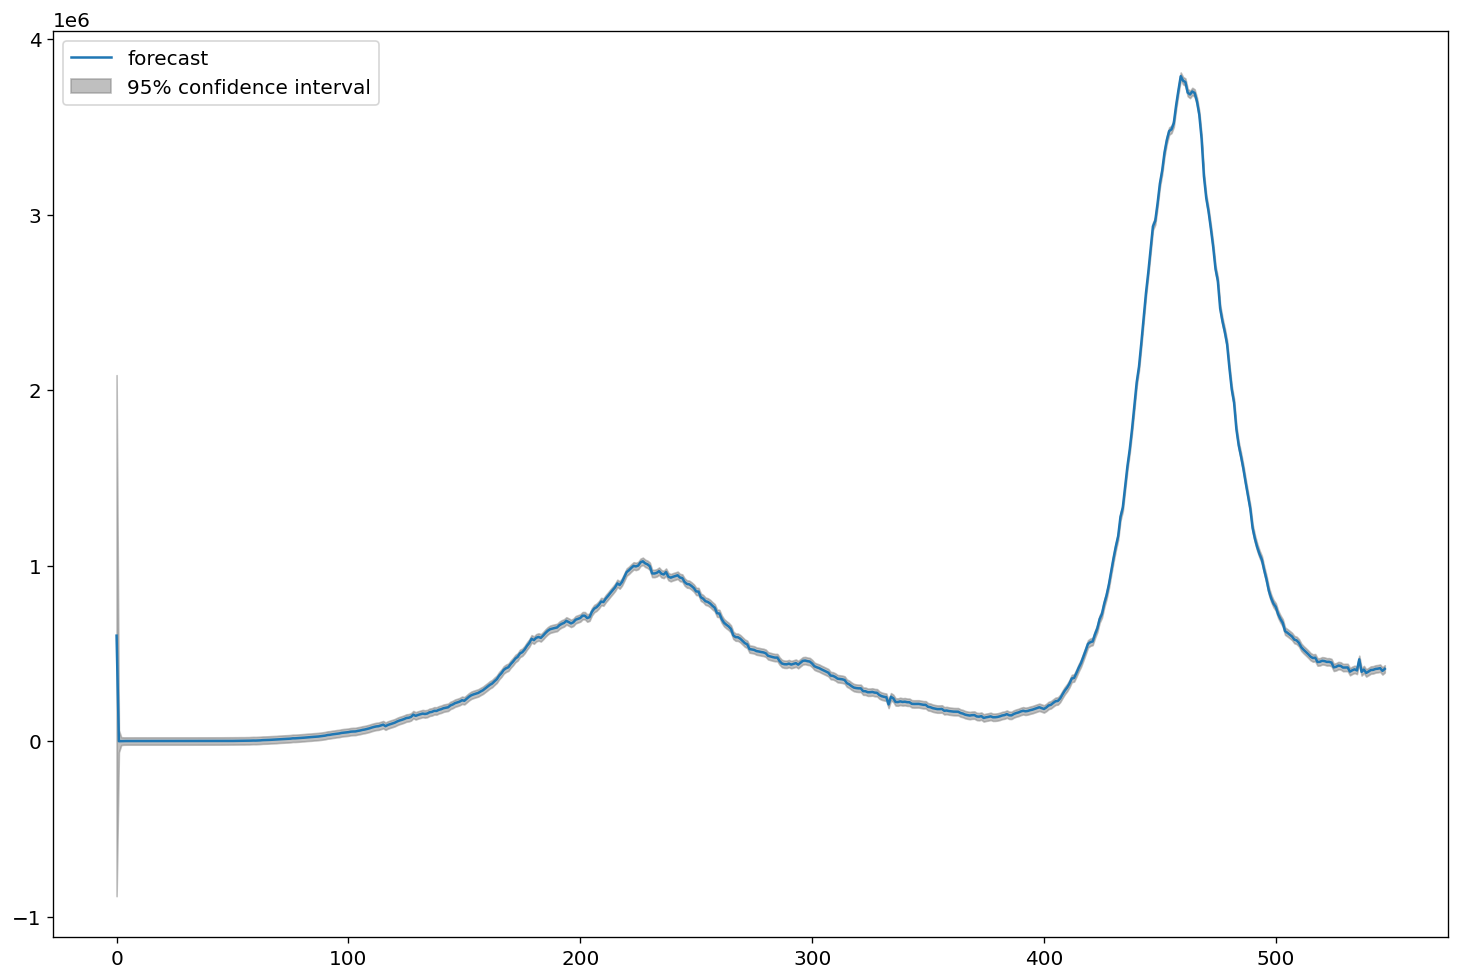

<IPython.core.display.Javascript object>

In [17]:
best_order = (2, 0, 1)
model = ARIMA(df, order=best_order)
model_fit = model.fit()
print(model_fit.summary())
plot_predict(model_fit, figsize=(10, 5))
plt.savefig("Graphs/forecast_active_india.jpg")
plt.show()

In [18]:
model = ARIMA(df, order=(2, 0, 1))
fitted = model.fit()
print(fitted.summary())

# Forecast
fc = fitted.forecast(100, alpha=0.05)  # 95% conf
print(fc.shape)
# Make as pandas series
fc_series = fc.to_numpy().reshape(100, -1)
# lower_series = pd.Series(conf[:, 0], index=test.index)
# upper_series = pd.Series(conf[:, 1], index=test.index)

# # Plot
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(train, label='training')
# plt.plot(test, label='actual')
# plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series,
#                  color='k', alpha=.15)
# plt.title('Forecast vs Actuals')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

                               SARIMAX Results                                
Dep. Variable:                  cases   No. Observations:                  548
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -5857.710
Date:                Sat, 03 Dec 2022   AIC                          11725.420
Time:                        22:03:55   BIC                          11746.951
Sample:                             0   HQIC                         11733.836
                                - 548                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.018e+05   3.22e-10   1.87e+15      0.000    6.02e+05    6.02e+05
ar.L1          1.9756      0.005    430.324      0.000       1.967       1.985
ar.L2         -0.9773      0.005   -212.516      0.0

<IPython.core.display.Javascript object>

### Accuracy metrics

In [19]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)  # ME
    mae = np.mean(np.abs(forecast - actual))  # MAE
    mpe = np.mean((forecast - actual) / actual)  # MPE
    rmse = np.mean((forecast - actual) ** 2) ** 0.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]  # corr
    mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins / maxs)  # minmax
    #     acf1 = acf(fc-test)[1]                      # ACF1
    return {
        "mape": mape,
        "me": me,
        "mae": mae,
        "mpe": mpe,
        "rmse": rmse,
        "corr": corr,
        "minmax": minmax,
    }


# print (fc_series.reshape(100, -1).shape, df[-100:].to_numpy().shape)

forecast_accuracy(fc_series, df[-100:].to_numpy())

{'mape': 0.5841545511705415,
 'me': -944110.4420421618,
 'mae': 1125977.771178266,
 'mpe': -0.16734575900898296,
 'rmse': 1638899.6755399422,
 'corr': nan,
 'minmax': 0.5114876895018783}

<IPython.core.display.Javascript object>

In [20]:
RMSE = []
ARIMA_model = []

mod = sm.tsa.arima.ARIMA(
    df, order=(11, 1, 5), enforce_stationarity=False, enforce_invertibility=False
)
results = mod.fit()
print(f"ARIMA - MSE:{results.mse}", end="\r")
RMSE.append(math.sqrt(results.mse))
# ARIMA_model.append(param)
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  cases   No. Observations:                  548
Model:                ARIMA(11, 1, 5)   Log Likelihood               -5805.469
Date:                Sat, 03 Dec 2022   AIC                          11644.937
Time:                        22:04:03   BIC                          11717.767
Sample:                             0   HQIC                         11673.430
                                - 548                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6770      0.111    -15.164      0.000      -1.894      -1.460
ar.L2          0.4835      0.123      3.947      0.000       0.243       0.724
ar.L3          1.9616      0.149     13.180      0.0

<IPython.core.display.Javascript object>

In [21]:
RMSE

[11419.838455182393]

<IPython.core.display.Javascript object>

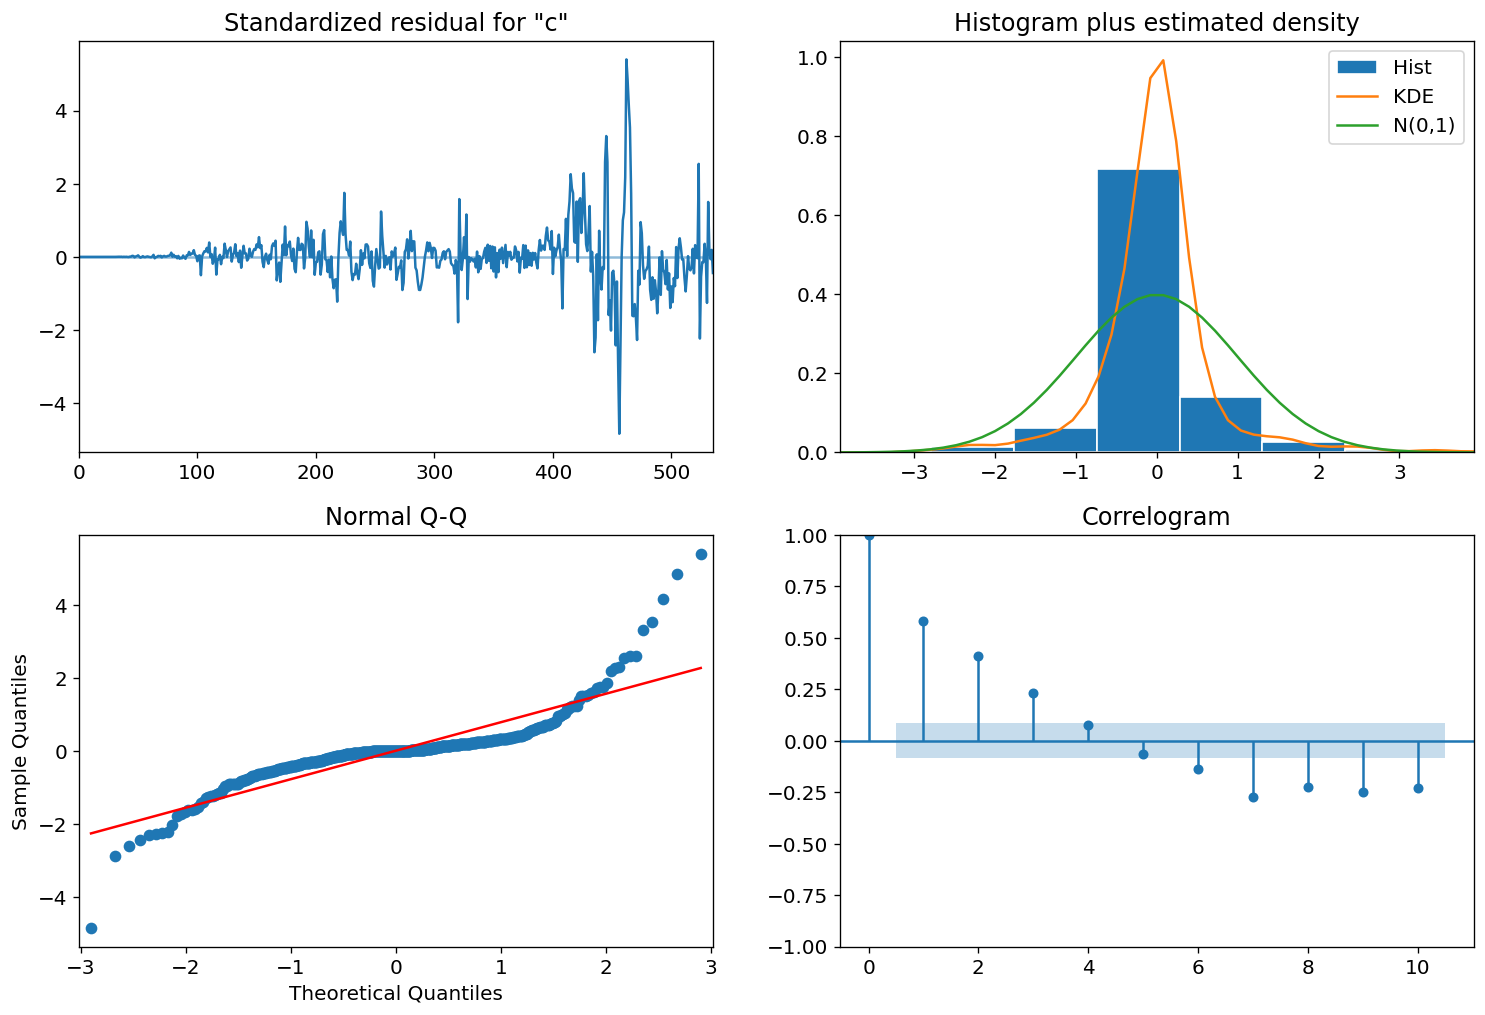

<IPython.core.display.Javascript object>

In [22]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

In [23]:
testdata = active_df["2020-01-22":"2021-04-22"]
testdf = pd.DataFrame((testdata[country].to_numpy()), columns={"cases"})

<IPython.core.display.Javascript object>

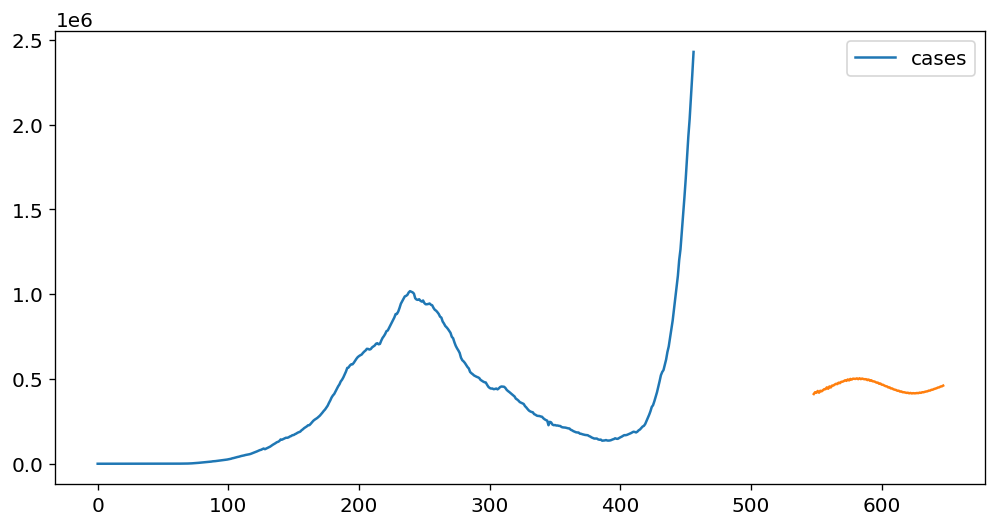

<IPython.core.display.Javascript object>

In [24]:
pred = results.get_forecast(100)
ax = testdf.plot(figsize=(10, 5))
pred.predicted_mean.plot(ax=ax, label="Dynamic Forecast (get_forecast)")
plt.show()

## Implementing ANN

In [25]:
df = active_df
df

Country/Region,France,Germany,India,Iran,Italy,Russia,Spain,Turkey,US,United Kingdom
2020-01-22,0,0,0,0,0,0,0,0,1,0
2020-01-23,0,0,0,0,0,0,0,0,1,0
2020-01-24,2,0,0,0,0,0,0,0,2,0
2020-01-25,3,0,0,0,0,0,0,0,2,0
2020-01-26,3,0,0,0,0,0,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...
2022-10-27,36806978,35370035,44120089,7412572,23296247,20715660,13373157,16818435,96348131,23911263
2022-10-28,36832700,35417586,44121654,7412675,23325199,20723100,13396690,16818435,96378117,23911498
2022-10-29,36832700,35417586,44123240,7412793,23351922,20730059,13396690,16818435,96387064,23911498
2022-10-30,36832700,35417587,44124568,7412866,23351922,20736706,13396690,16818435,96390317,23911498


<IPython.core.display.Javascript object>

In [26]:
df = pd.read_excel("Active.xlsx")
df

,Unnamed: 0,France,Germany,India,Iran,Italy,Russia,Spain,Turkey,US,United Kingdom
0,2020-01-22,0,0,0,0,0,0,0,0,1,0
1,2020-01-23,0,0,0,0,0,0,0,0,1,0
2,2020-01-24,2,0,0,0,0,0,0,0,2,0
3,2020-01-25,3,0,0,0,0,0,0,0,2,0
4,2020-01-26,3,0,0,0,0,0,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...
1009,2022-10-27,36806978,35370035,44120089,7412572,23296247,20715660,13373157,16818435,96348131,23911263
1010,2022-10-28,36832700,35417586,44121654,7412675,23325199,20723100,13396690,16818435,96378117,23911498
1011,2022-10-29,36832700,35417586,44123240,7412793,23351922,20730059,13396690,16818435,96387064,23911498
1012,2022-10-30,36832700,35417587,44124568,7412866,23351922,20736706,13396690,16818435,96390317,23911498


<IPython.core.display.Javascript object>

In [27]:
df = pd.DataFrame((df["India"].to_numpy()), columns={"cases"})
df.shape
df = df.transform("sqrt")

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Cases')

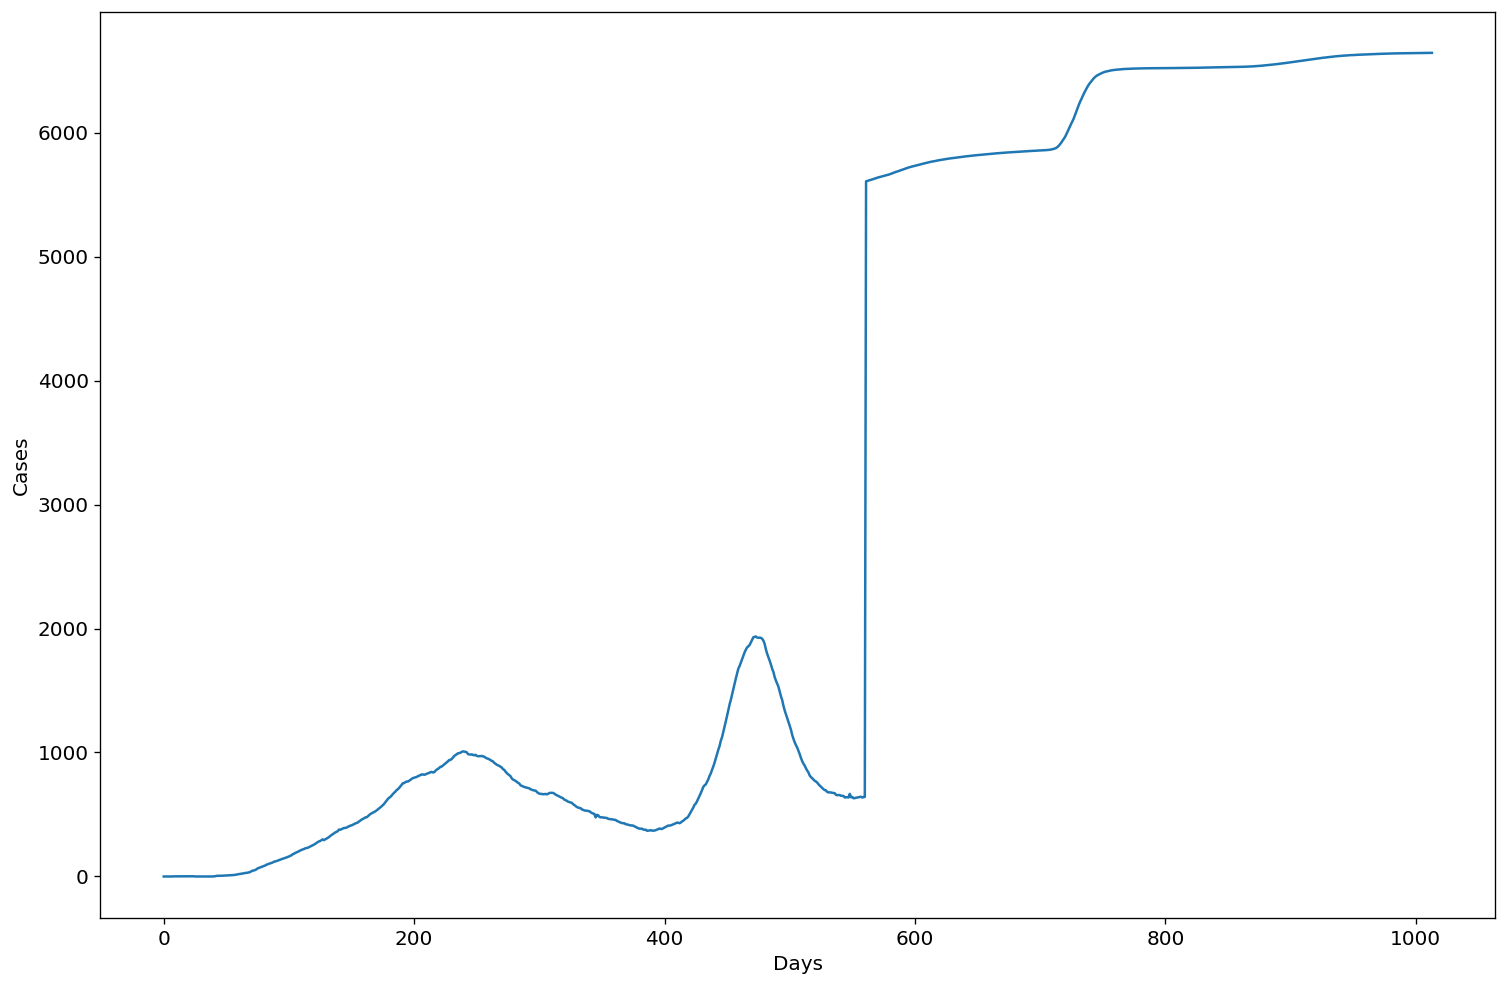

<IPython.core.display.Javascript object>

In [28]:
plt.plot(df)
plt.xlabel("Days")
plt.ylabel("Cases")

## Train-Test Split

In [29]:
test_df = df[-100:]
train_df = df[:-100]

<IPython.core.display.Javascript object>

In [30]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_df)

MinMaxScaler()

<IPython.core.display.Javascript object>

## Artificial Neural Networks

### Functions


In [31]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

<IPython.core.display.Javascript object>

In [32]:
def calculate_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return round(mse, 3), round(mae, 3), round(mape, 3), round(rmse, 3)

<IPython.core.display.Javascript object>

In [33]:
def plot_keras_model(model, show_shapes=True, show_layer_names=True):
    return SVG(
        model_to_dot(
            model, show_shapes=show_shapes, show_layer_names=show_layer_names
        ).create(prog="dot", format="svg")
    )

<IPython.core.display.Javascript object>

In [34]:
def get_combinations(parameters):
    return list(itertools.product(*parameters))


<IPython.core.display.Javascript object>

In [35]:
def create_NN(input_nodes, hidden_nodes, output_nodes):
    model = Sequential()
    model.add(Dense(int(hidden_nodes), input_dim=int(input_nodes)))
    model.add(Dense(int(output_nodes)))
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

<IPython.core.display.Javascript object>

### Train Model

In [36]:
def train_model(model, X_train, y_train, epochs, batch_size):
    model.fit(
        X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True
    )
    return model

<IPython.core.display.Javascript object>

In [37]:
def reshape_arrays(X_train, y_train):
    X_train = np.array(X_train)
    y_train = np.reshape(y_train, (len(y_train), 1))
    return X_train, y_train

<IPython.core.display.Javascript object>

## Feed Forward ANN

### Data Preprocessing

In [38]:
def preprocess_FNN(data, look_back):
    data = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(data.shape[0] - look_back):
        x = data[i : look_back + i][::-1]
        y = data[look_back + i]
        X_train.append(list(x))
        y_train.append(y)
    input_seq_for_test = data[i + 1 : look_back + i + 1][::-1]
    return X_train, y_train, input_seq_for_test

<IPython.core.display.Javascript object>

### Feed Forward ANN Forecast

In [39]:
def forecast_FNN(model, input_sequence, future_steps):
    forecasted_values = []
    for i in range(future_steps):
        forecasted_value = model.predict(input_sequence)
        forecasted_values.append(forecasted_value[0][0])
        input_sequence[0] = np.append(forecasted_value, input_sequence[0][:-1])
    return forecasted_values

<IPython.core.display.Javascript object>

### Feed Forward Network

In [40]:
def FNN(
    data,
    look_back,
    hidden_nodes,
    output_nodes,
    epochs,
    batch_size,
    future_steps,
    scaler,
):
    data = scaler.transform(data)
    X_train, y_train, input_seq_for_test_FNN = preprocess_FNN(data, look_back)
    X_train, y_train = reshape_arrays(X_train, y_train)

    model_FNN = create_NN(
        input_nodes=look_back, hidden_nodes=hidden_nodes, output_nodes=output_nodes
    )
    model_FNN = train_model(model_FNN, X_train, y_train, epochs, batch_size)

    input_seq_for_test_FNN = np.reshape(
        input_seq_for_test_FNN, (1, len(input_seq_for_test_FNN))
    )
    forecasted_values_FNN = forecast_FNN(
        model_FNN, input_sequence=input_seq_for_test_FNN, future_steps=future_steps
    )

    forecasted_values_FNN = list(scaler.inverse_transform([forecasted_values_FNN])[0])

    return model_FNN, forecasted_values_FNN

<IPython.core.display.Javascript object>

### FNN scores

In [41]:
def get_accuracies_FNN(rainfall_data, test_rainfall_data, parameters, scaler):
    combination_of_params = get_combinations(parameters)
    information_FNN = []
    iterator = 0
    print("FNN - Number of combinations: " + str(len(combination_of_params)))

    for param in combination_of_params:
        if (iterator + 1) != len(combination_of_params):
            print(iterator + 1, end=" -> ")
        else:
            print(iterator + 1)
        iterator = iterator + 1

        look_back = param[0]
        hidden_nodes = param[1]
        output_nodes = param[2]
        epochs = param[3]
        batch_size = param[4]
        future_steps = param[5]

        model_FNN, forecasted_values_FNN = FNN(
            rainfall_data,
            look_back,
            hidden_nodes,
            output_nodes,
            epochs,
            batch_size,
            future_steps,
            scaler,
        )

        y_true = test_rainfall_data.iloc[:future_steps]
        mse, mae, mape, rmse = calculate_performance(y_true, forecasted_values_FNN)

        info = list(param) + [mse, mae, rmse] + forecasted_values_FNN
        information_FNN.append(info)

    information_FNN_df = pd.DataFrame(information_FNN)
    indexes = [str(i) for i in list(range(1, future_steps + 1))]
    information_FNN_df.columns = [
        "look_back",
        "hidden_nodes",
        "output_nodes",
        "epochs",
        "batch_size",
        "future_steps",
        "MSE",
        "MAE",
        "RMSE",
    ] + indexes
    return information_FNN_df

<IPython.core.display.Javascript object>

## Time Lagged Neural Networks

### Data Preprocessing

In [42]:
def preprocess_TLNN(data, time_lagged_points):
    data = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(max(time_lagged_points), data.shape[0]):
        x = [data[i - p] for p in time_lagged_points]
        y = data[i]
        X_train.append(list(x))
        y_train.append(y)
    input_seq_for_test = [data[i + 1 - p] for p in time_lagged_points]
    return X_train, y_train, input_seq_for_test

<IPython.core.display.Javascript object>

### TLNN Forecast

In [43]:
def forecast_TLNN(model, time_lagged_points, last_sequence, future_steps):
    forecasted_values = []
    max_lag = max(time_lagged_points)
    for i in range(future_steps):
        input_sequence = [last_sequence[max_lag - p] for p in time_lagged_points]
        forecasted_value = model.predict(
            np.reshape(input_sequence, (1, len(input_sequence)))
        )
        forecasted_values.append(forecasted_value[0][0])
        last_sequence = last_sequence[1:] + [forecasted_value[0][0]]
    return forecasted_values

<IPython.core.display.Javascript object>

### Time Lagged Neural Networks

In [44]:
def TLNN(
    data,
    time_lagged_points,
    hidden_nodes,
    output_nodes,
    epochs,
    batch_size,
    future_steps,
    scaler,
):
    data = scaler.transform(data)
    X_train, y_train, input_seq_for_test_TLNN = preprocess_TLNN(
        data, time_lagged_points
    )
    X_train, y_train = reshape_arrays(X_train, y_train)
    model_TLNN = create_NN(
        input_nodes=len(time_lagged_points),
        hidden_nodes=hidden_nodes,
        output_nodes=output_nodes,
    )
    model_TLNN = train_model(model_TLNN, X_train, y_train, epochs, batch_size)

    max_lag = max(time_lagged_points)
    forecasted_values_TLNN = forecast_TLNN(
        model_TLNN, time_lagged_points, list(data[-max_lag:]), future_steps=future_steps
    )
    forecasted_values_TLNN = list(scaler.inverse_transform([forecasted_values_TLNN])[0])

    return model_TLNN, forecasted_values_TLNN

<IPython.core.display.Javascript object>

### TLNN Scores

In [45]:
def get_accuracies_TLNN(rainfall_data, test_rainfall_data, parameters, scaler):
    combination_of_params = get_combinations(parameters)
    information_TLNN = []
    iterator = 0
    print("TLNN - Number of combinations: " + str(len(combination_of_params)))

    for param in combination_of_params:
        if (iterator + 1) != len(combination_of_params):
            print(iterator + 1, end=" -> ")
        else:
            print(iterator + 1)
        iterator = iterator + 1

        time_lagged_points = param[0]
        hidden_nodes = param[1]
        output_nodes = param[2]
        epochs = param[3]
        batch_size = param[4]
        future_steps = param[5]

        model_TLNN, forecasted_values_TLNN = TLNN(
            rainfall_data,
            time_lagged_points,
            hidden_nodes,
            output_nodes,
            epochs,
            batch_size,
            future_steps,
            scaler,
        )

        y_true = test_rainfall_data.iloc[:future_steps]
        mse, mae, mape, rmse = calculate_performance(y_true, forecasted_values_TLNN)

        info = list(param) + [mse, mae, rmse] + forecasted_values_TLNN
        information_TLNN.append(info)

    information_TLNN_df = pd.DataFrame(information_TLNN)
    indexes = [str(i) for i in list(range(1, future_steps + 1))]
    information_TLNN_df.columns = [
        "look_back_lags",
        "hidden_nodes",
        "output_nodes",
        "epochs",
        "batch_size",
        "future_steps",
        "MSE",
        "MAE",
        "RMSE",
    ] + indexes
    return information_TLNN_df

<IPython.core.display.Javascript object>

## Seasonal Artificial Neural Networks

In [46]:
def preprocess_SANN(data, seasonal_period):
    data = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(seasonal_period, data.shape[0] - seasonal_period + 1):
        x = data[i - seasonal_period : i][::-1]
        y = data[i : i + seasonal_period]
        X_train.append(list(x))
        y_train.append(list(y))
    input_seq_for_test = data[i + 1 - seasonal_period : i + 1][::-1]
    return X_train, y_train, input_seq_for_test

<IPython.core.display.Javascript object>

### SANN Preprocessing

In [47]:
def forecast_SANN(model, input_sequence, seasonal_period, future_steps):
    iterations = future_steps / seasonal_period
    forecasted_values = []
    for i in range(int(iterations) + 1):
        next_forecasted_values = model.predict(input_sequence)
        forecasted_values += list(next_forecasted_values[0])
        input_sequence = next_forecasted_values
    return forecasted_values[:future_steps]

<IPython.core.display.Javascript object>

### SANN Forecast

In [48]:
def forecast_SANN(model, input_sequence, seasonal_period, future_steps):
    iterations = future_steps / seasonal_period
    forecasted_values = []
    for i in range(int(iterations) + 1):
        next_forecasted_values = model.predict(input_sequence)
        forecasted_values += list(next_forecasted_values[0])
        input_sequence = next_forecasted_values
    return forecasted_values[:future_steps]

<IPython.core.display.Javascript object>

### SANN

In [49]:
def SANN(data, seasonal_period, hidden_nodes, epochs, batch_size, future_steps, scaler):
    data = scaler.transform(data)
    X_train, y_train, input_seq_for_test_SANN = preprocess_SANN(data, seasonal_period)
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    input_seq_for_test_SANN = np.reshape(
        input_seq_for_test_SANN, (1, len(input_seq_for_test_SANN))
    )
    model_SANN = create_NN(
        input_nodes=seasonal_period,
        hidden_nodes=hidden_nodes,
        output_nodes=seasonal_period,
    )
    model_SANN = train_model(model_SANN, X_train, y_train, epochs, batch_size)

    forecasted_values_SANN = forecast_SANN(
        model_SANN, input_seq_for_test_SANN, seasonal_period, future_steps=future_steps
    )
    forecasted_values_SANN = list(scaler.inverse_transform([forecasted_values_SANN])[0])
    return model_SANN, forecasted_values_SANN

<IPython.core.display.Javascript object>

### SANN Scores

In [50]:
def get_accuracies_SANN(rainfall_data, test_rainfall_data, parameters, scaler):
    combination_of_params = get_combinations(parameters)
    information_SANN = []
    iterator = 0
    print("SANN - Number of combinations: " + str(len(combination_of_params)))

    for param in combination_of_params:
        if (iterator + 1) != len(combination_of_params):
            print(iterator + 1, end=" -> ")
        else:
            print(iterator + 1)
        iterator = iterator + 1

        seasonal_period = param[0]
        hidden_nodes = param[1]
        epochs = param[2]
        batch_size = param[3]
        future_steps = param[4]

        model_SANN, forecasted_values_SANN = SANN(
            rainfall_data,
            seasonal_period,
            hidden_nodes,
            epochs,
            batch_size,
            future_steps,
            scaler,
        )

        y_true = test_rainfall_data.iloc[:future_steps]
        mse, mae, mape, rmse = calculate_performance(y_true, forecasted_values_SANN)

        info = list(param) + [mse, mae, rmse] + forecasted_values_SANN
        information_SANN.append(info)

    information_SANN_df = pd.DataFrame(information_SANN)
    indexes = [str(i) for i in list(range(1, future_steps + 1))]
    information_SANN_df.columns = [
        "seasonal_period",
        "hidden_nodes",
        "epochs",
        "batch_size",
        "future_steps",
        "MSE",
        "MAE",
        "RMSE",
    ] + indexes
    return information_SANN_df

<IPython.core.display.Javascript object>

## Long Short Term Memory (LSTM)

### LSTM Network

In [51]:
def create_LSTM(input_nodes, hidden_nodes, output_nodes):
    model = Sequential()
    model.add(LSTM(hidden_nodes, input_shape=(1, input_nodes)))
    model.add(Dense(output_nodes))
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

<IPython.core.display.Javascript object>

### LSTM Preprocessing

In [52]:
def preprocess_LSTM(data, look_back):
    data = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(data.shape[0] - look_back):
        x = data[i : look_back + i][::-1]
        y = data[look_back + i]
        X_train.append(list(x))
        y_train.append(y)
    input_seq_for_test = data[i + 1 : look_back + i + 1][::-1]
    return X_train, y_train, input_seq_for_test

<IPython.core.display.Javascript object>

### LSTM Forecasting


In [53]:
def forecast_LSTM(model, input_sequence, future_steps):
    forecasted_values = []
    for i in range(future_steps):
        forecasted_value = model.predict(input_sequence)
        forecasted_values.append(forecasted_value[0][0])
        input_sequence[0][0] = np.append(forecasted_value, input_sequence[0][0][:-1])
    return forecasted_values

<IPython.core.display.Javascript object>

### Long Short Term Memory

In [54]:
def Long_Short_Term_Memory(
    data,
    look_back,
    hidden_nodes,
    output_nodes,
    epochs,
    batch_size,
    future_steps,
    scaler,
):
    data = scaler.transform(data)
    X_train, y_train, input_seq_for_test_LSTM = preprocess_LSTM(data, look_back)
    X_train = np.reshape(X_train, (len(X_train), 1, look_back))

    model_LSTM = create_LSTM(
        input_nodes=look_back, hidden_nodes=hidden_nodes, output_nodes=output_nodes
    )
    # plot_keras_model(model_LSTM)
    model_LSTM = train_model(model_LSTM, X_train, y_train, epochs, batch_size)

    input_seq_for_test_LSTM = np.reshape(
        input_seq_for_test_LSTM, (1, 1, len(input_seq_for_test_LSTM))
    )
    forecasted_values_LSTM = forecast_LSTM(
        model_LSTM, input_sequence=input_seq_for_test_LSTM, future_steps=future_steps
    )

    forecasted_values_LSTM = list(scaler.inverse_transform([forecasted_values_LSTM])[0])

    return model_LSTM, forecasted_values_LSTM

<IPython.core.display.Javascript object>

### LSTM scores

In [55]:
def get_accuracies_LSTM(rainfall_data, test_rainfall_data, parameters, scaler):
    combination_of_params = get_combinations(parameters)
    information_LSTM = []
    iterator = 0
    print("LSTM - Number of combinations: " + str(len(combination_of_params)))

    for param in combination_of_params:
        if (iterator + 1) != len(combination_of_params):
            print(iterator + 1, end=" -> ")
        else:
            print(iterator + 1)
        iterator = iterator + 1

        input_nodes = param[0]
        hidden_nodes = param[1]
        output_nodes = param[2]
        epochs = param[3]
        batch_size = param[4]
        future_steps = param[5]

        model_LSTM, forecasted_values_LSTM = Long_Short_Term_Memory(
            rainfall_data,
            input_nodes,
            hidden_nodes,
            output_nodes,
            epochs,
            batch_size,
            future_steps,
            scaler,
        )

        y_true = test_rainfall_data.iloc[:future_steps]
        mse, mae, mape, rmse = calculate_performance(y_true, forecasted_values_LSTM)

        info = list(param) + [mse, mae, rmse] + forecasted_values_LSTM
        information_LSTM.append(info)

    information_LSTM_df = pd.DataFrame(information_LSTM)
    indexes = [str(i) for i in list(range(1, future_steps + 1))]
    information_LSTM_df.columns = [
        "look_back",
        "hidden_nodes",
        "output_nodes",
        "epochs",
        "batch_size",
        "future_steps",
        "MSE",
        "MAE",
        "RMSE",
    ] + indexes
    return information_LSTM_df

<IPython.core.display.Javascript object>

### Analyze the test data and forecasted data

In [56]:
def analyze_results(data_frame, test_rainfall_data, name, flag=False):
    optimized_params = data_frame.iloc[data_frame.RMSE.argmin()]
    future_steps = optimized_params.future_steps
    forecast_values = optimized_params[-1 * int(future_steps) :]
    y_true = test_rainfall_data.iloc[: int(future_steps)]
    forecast_values.index = y_true.index

    print("=== Best parameters of " + name + " ===\n")
    if name == "FNN" or name == "LSTM":
        model = create_NN(
            optimized_params.look_back,
            optimized_params.hidden_nodes,
            optimized_params.output_nodes,
        )
        print("Input nodes(p): " + str(optimized_params.look_back))
        print("Hidden nodes: " + str(optimized_params.hidden_nodes))
        print("Output nodes: " + str(optimized_params.output_nodes))
    elif name == "TLNN":
        model = create_NN(
            len(optimized_params.look_back_lags),
            optimized_params.hidden_nodes,
            optimized_params.output_nodes,
        )
        s = ""
        for i in optimized_params.look_back_lags:
            s = s + " " + str(i)
        print("Look back lags: " + s)
        print("Hidden nodes: " + str(optimized_params.hidden_nodes))
        print("Output nodes: " + str(optimized_params.output_nodes))
    elif name == "SANN":
        model = create_NN(
            optimized_params.seasonal_period,
            optimized_params.hidden_nodes,
            optimized_params.seasonal_period,
        )
        print("Input nodes(s): " + str(optimized_params.seasonal_period))
        print("Hidden nodes: " + str(optimized_params.hidden_nodes))
        print("Output nodes: " + str(optimized_params.seasonal_period))

    print("Number of epochs: " + str(optimized_params.epochs))
    print("Batch size: " + str(optimized_params.batch_size))
    print("Number of future steps forecasted: " + str(optimized_params.future_steps))
    print("Mean Squared Error(MSE): " + str(optimized_params.MSE))
    print("Mean Absolute Error(MAE): " + str(optimized_params.MAE))
    print("Root Mean Squared Error(RMSE): " + str(optimized_params.RMSE))
    print("\n\n")

    # Save model
    from keras.utils import plot_model

    #     plot_model(model, to_file = STORAGE_FOLDER + name + '_best_fit_model.png', show_shapes=True, show_layer_names=True)

    #     # Save data
    #     data_frame.to_csv(STORAGE_FOLDER + name + '_information.csv')
    #     optimized_params.to_csv(STORAGE_FOLDER + name + '_optimized_values.csv')

    plt.figure(figsize=(10, 5))
    plt.plot(y_true, color="green", label="Actual values")
    plt.plot(forecast_values, color="red", label="Forecasted values")
    plt.xlabel("Year")
    plt.ylabel("Monthly mean Precipitation")
    plt.legend(loc="best")
    if flag == False:
        plt.title(name + " - Comaprison: Actual vs Forecasted")
    #         plt.savefig(STORAGE_FOLDER + name + '_best_forecast'  + '.png')
    else:
        plt.title("Best of all: " + name + " - Comaprison: Actual vs Forecasted")
    #         plt.savefig(STORAGE_FOLDER + 'BEST_FORECAST_' + name + '.png')

    return optimized_params

<IPython.core.display.Javascript object>

### Pick the Best Method

In [57]:
def best_of_all(list_of_methods):
    RMSE_values = [x.RMSE for x in list_of_methods]
    index = np.argmin(RMSE_values)
    if index == 0:
        name = "FNN"
    elif index == 1:
        name = "TLNN"
    elif index == 2:
        name = "SANN"
    else:
        name = "LSTM"
    print(RMSE_values)

    names = ["FNN", "TLNN", "SANN", "LSTM"]
    RMSE_info = pd.Series(RMSE_values, index=names)

    print("Overall Best method on this data is " + name)
    return index, name, RMSE_info

<IPython.core.display.Javascript object>

### Compare Results of above algorithms

In [58]:
def compare_ANN_methods(
    rainfall_data,
    test_rainfall_data,
    scaler,
    parameters_FNN,
    parameters_TLNN,
    parameters_SANN,
    parameters_LSTM,
    future_steps,
):

    information_FNN_df = get_accuracies_FNN(
        rainfall_data, test_rainfall_data, parameters_FNN, scaler
    )
    optimized_params_FNN = analyze_results(
        information_FNN_df, test_rainfall_data, "FNN"
    )

    # information_TLNN_df = get_accuracies_TLNN(rainfall_data, test_rainfall_data, parameters_TLNN, scaler)
    # optimized_params_TLNN = analyze_results(information_TLNN_df, test_rainfall_data, 'TLNN')

    # information_SANN_df = get_accuracies_SANN(rainfall_data, test_rainfall_data, parameters_SANN, scaler)
    # optimized_params_SANN = analyze_results(information_SANN_df, test_rainfall_data, 'SANN')

    # information_LSTM_df = get_accuracies_LSTM(rainfall_data, test_rainfall_data, parameters_LSTM, scaler)
    # optimized_params_LSTM = analyze_results(information_LSTM_df, test_rainfall_data, 'LSTM')

    list_of_methods = [
        optimized_params_FNN,
        optimized_params_TLNN,
        optimized_params_SANN,
        optimized_params_LSTM,
    ]
    information = [
        information_FNN_df,
        information_TLNN_df,
        information_SANN_df,
        information_LSTM_df,
    ]
    index, name, RMSE_info = best_of_all(list_of_methods)
    best_optimized_params = analyze_results(
        information[index], test_rainfall_data, name, True
    )
    return RMSE_info

<IPython.core.display.Javascript object>

### Number of Future steps to be forecasted

In [59]:
future_steps = 100

<IPython.core.display.Javascript object>

### Initialize all the parameters

In [ ]:
# look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_FNN = [
    [1, 2, 3, 6, 8, 10, 12],
    [3, 4, 5, 6],
    [1],
    [500],
    [20],
    [future_steps],
]

# time_lagged_points, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_TLNN = [
    [
        [1, 2, 3, 11, 12],
        [1, 2, 3, 4, 11, 12],
        [1, 2, 3, 11, 12, 13],
        [1, 2, 3, 4, 5, 6, 10, 11, 12],
    ],
    [3, 4, 5, 6],
    [1],
    [300],
    [20],
    [future_steps],
]

# seasonal_period, hidden_nodes, epochs, batch_size, future_steps
parameters_SANN = [[12], [3, 4, 5, 6, 7, 8, 9, 10], [500], [20], [future_steps]]

# look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_LSTM = [
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
    [3, 4, 5, 6],
    [1],
    [300],
    [20],
    [future_steps],
]

FNN - Number of combinations: 28
1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step
28
1/1 [==============================] - 0s 26ms/step
=== Best parameters of FNN ===

Input nodes(p): 3.0
Hidden nodes: 5.0
Output nodes: 1.0
Number of epochs: 500.0
Batch size: 20.0
Number of future steps forecasted: 100.0
Mean Squared Error(MSE): 533.002
Mean Absolute Error(MAE): 16.43
Root Mean Squared Error(RMSE): 23.087





NameError: name 'optimized_params_TLNN' is not defined

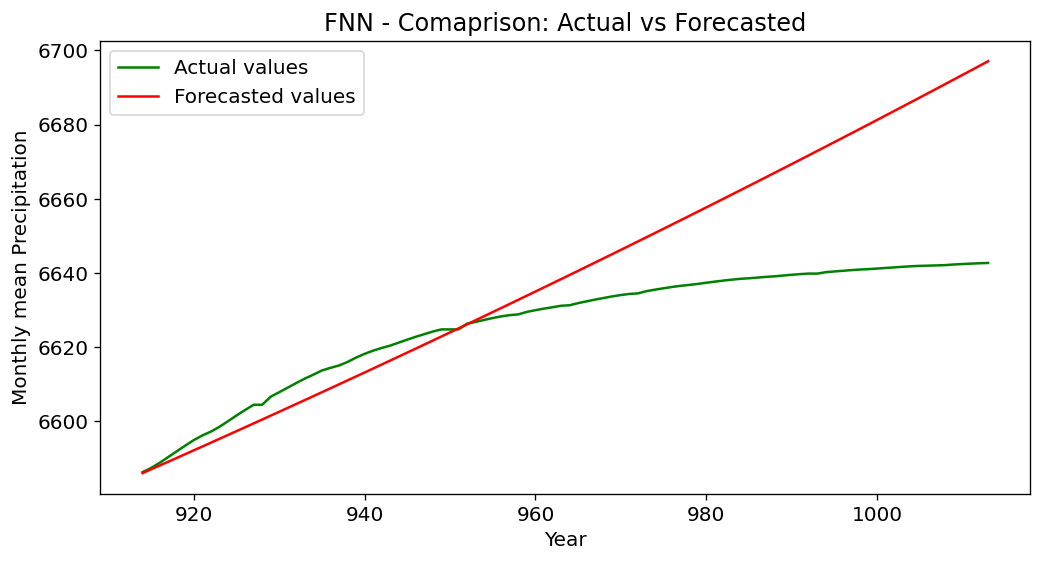

<IPython.core.display.Javascript object>

In [61]:
RMSE_info = compare_ANN_methods(
    train_df,
    test_df,
    scaler,
    parameters_FNN,
    parameters_TLNN,
    parameters_SANN,
    parameters_LSTM,
    future_steps,
)